In [128]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Porto training dataset
data = pd.read_csv('creditcard.csv')

# Success
print "This dataset has {} data points with {} variables each.".format(*data.shape)

y=data['Class']
X=data.drop(['Class','Time'],axis = 1) #drop time class since the fraud transactions are not connected

print X.shape
print y.shape

data.info() #identify if there are any null values
data.keys() #identify the columns

This dataset has 284807 data points with 31 variables each.
(284807, 29)
(284807,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-nul

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')

In [130]:
percent_fraud = 100*float(np.sum(y))/len(X)
print "{0:0.4f} % of the dataset are fraudulent transactions".format(percent_fraud)

# pre-process the data to make it usable
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X = scaler.fit_transform(X)
print X.shape
print y.shape

0.1727 % of the dataset are fraudulent transactions
(284807, 29)
(284807,)


In [62]:
# intermediate code to find highest value of amounts tagged as fraud
high_fraud_amounts = data.loc[data['Class']==1].sort_values(by=['Amount'],ascending=False)
high_fraud_amounts = high_fraud_amounts['Amount']
display(high_fraud_amounts.head())

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
Name: Amount, dtype: float64

##Visualization and Exploration
#Next, we will visualize the data to explore it before doing any classification

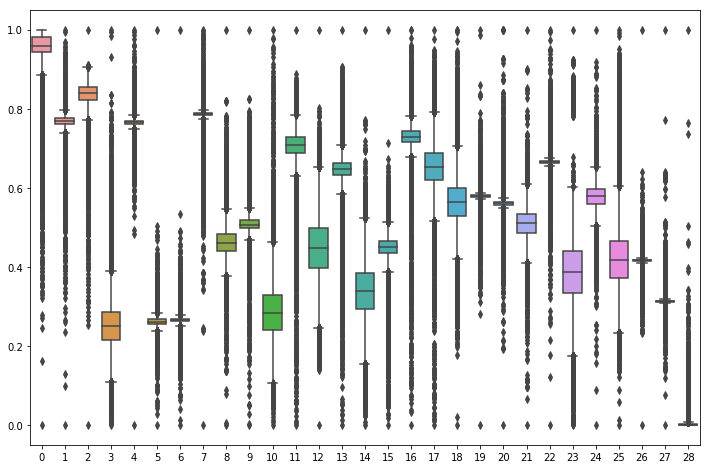

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
sns.boxplot(data=X)

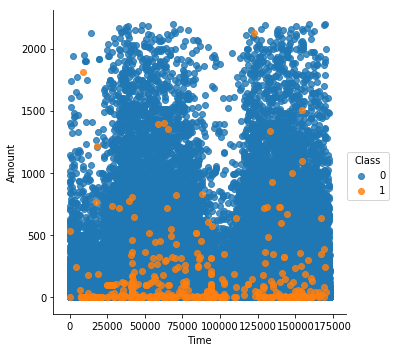

In [8]:
amount_class_df=data[['Amount','Time','Class']].loc[data['Amount']<2200.]
sns.lmplot(x='Time', y='Amount', data=amount_class_df,fit_reg=False,hue='Class')
#sns.lmplot(x='Time', y='V1', data=data,fit_reg=False,hue='Class')

Interesting to note that there is no fraud for amounts greater than about $ 2,300.

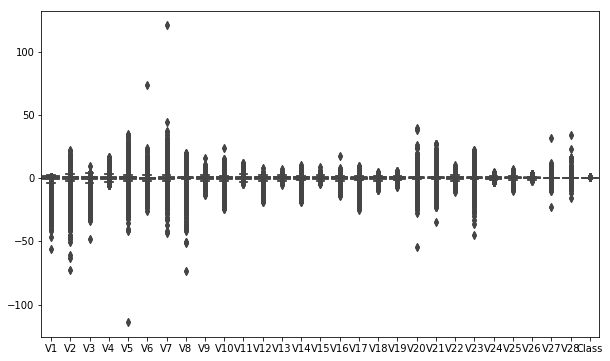

In [18]:
#violin plot for V1 to V28
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
feature_data=data.drop(['Amount','Time'],axis=1)
sns.boxplot(data=feature_data)
scaled_feature_data=scaler.fit_transform(feature_data)
sns.boxplot(data=scaled_feature_data)
sns.boxplot(data=feature_data)

sns.set_style('whitegrid')
sns.violinplot(x='Type 1', y='Class', data=df)

##Apply Classifiers to the dataset

In [33]:
# Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a classifier and fit it to the training set
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)
rand_y_pred_proba = rand_clf.predict_proba(X_test)

ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train,y_train)
ada_y_pred= ada_clf.predict(X_test)
ada_y_pred_proba= ada_clf.predict_proba(X_test)

from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=10,random_state=42) # avoid overfitting
dectree_clf.fit(X_train,y_train)
dectree_y_pred= dectree_clf.predict(X_test)
dectree_y_pred_proba= dectree_clf.predict_proba(X_test)

from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)
nb_y_pred= nb_clf.predict(X_test)
nb_y_pred_proba= nb_clf.predict_proba(X_test)

import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
xgboost_y_pred = gbm.predict(X_test)
xgboost_y_pred_proba = gbm.predict_proba(X_test)

In [156]:
# Report the prediction scores and plot precision recall curve for various classifiers
from sklearn.metrics import average_precision_score,recall_score,precision_recall_curve,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def draw_precision_recall(clf_name,clf,X,y,fig_num=1,n_folds=6):
    i=0
    mean_av_precision=0.
    mean_rec_score=0.
    
    plt.figure(fig_num)
    plt.figure(figsize=(10,6))

    cv=StratifiedKFold(n_splits=n_folds)
    
    for i,(train,test) in enumerate(cv.split(X,y)):
        clf.fit(X[train], y[train])
        y_probas_ = clf.predict_proba(X[test])
        y_pred=clf.predict(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], y_probas_[:, 1],pos_label=1)
        av_precision=average_precision_score(y[test], y_pred)
        rec_score=recall_score(y[test],y_pred)
        plt.plot(recall, precision, lw=1, label="PR fold {fold:1d} AP = {ap:0.4f} Recall = {rs:0.4f}".
                 format(fold=i,ap=av_precision,rs=rec_score)) 
        mean_av_precision+=av_precision
        mean_rec_score+=rec_score
        results.append(av_precision,rec_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])
    mean_av_precision/=n_folds
    mean_rec_score/=n_folds
    title = clf_name + (' Precision-Recall Curve Mean AP= {mean_av_p:0.3f} Mean Recall = {mean_rec_s:0.3f}').\
    format(mean_av_p=mean_av_precision,mean_rec_s=mean_rec_score)
    plt.legend(loc="lower right")
    plt.title(title)
    return results
    
def draw_roc_curve(clf_name,classifier,X,y,fig_num=2,n_folds=6,pos_label=1):
    plt.figure(fig_num)
    plt.figure(figsize=(10,6))
    # Compute ROC curve and area for the curve
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    cv=StratifiedKFold(n_splits=n_folds)
    for i,(train, test) in enumerate(cv.split(X,y)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clf_name + ' Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    
def feature_importance_graph(trained_clf):
    importances = trained_clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')
    
def output_classifier_score(clf_name,y_test,y_pred,y_pred_proba):
    print clf_name
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1])
    print "Average Precision = {0:0.4f} Recall Score = {0:0.4f}".format(
        average_precision,recall_score(y_test,y_pred))
    target_names=['OK','Fraud']
    print classification_report(y_test, y_pred, target_names=target_names,digits=4)

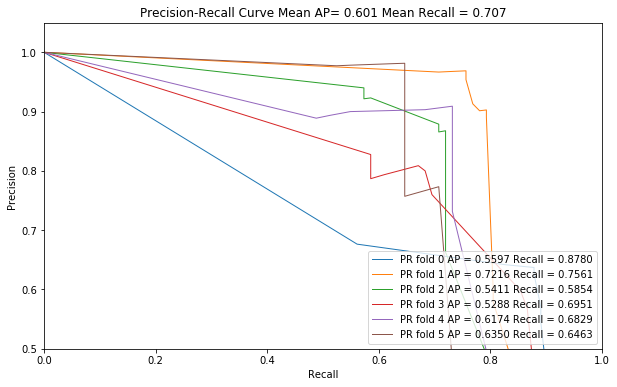

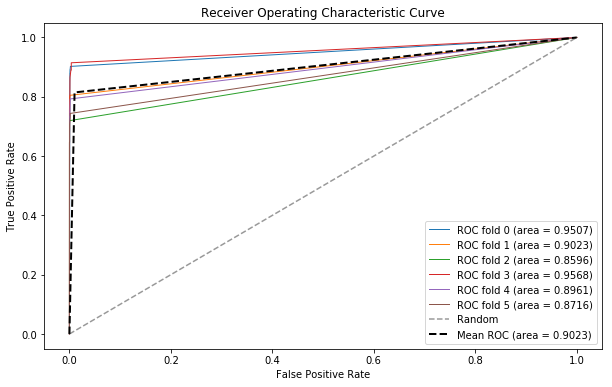

In [148]:
from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42)
draw_precision_recall(dectree_clf,X,y,1)
draw_roc_curve(dectree_clf,X,y,2)
plt.show()

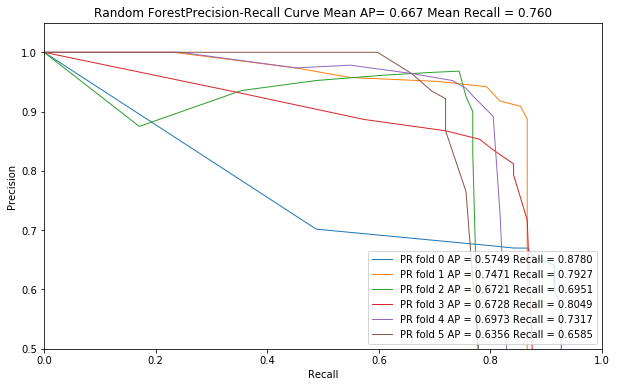

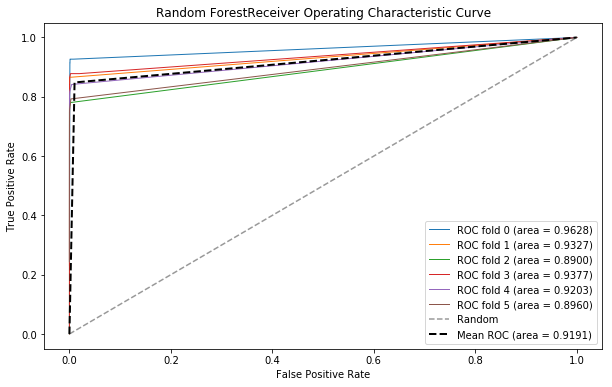

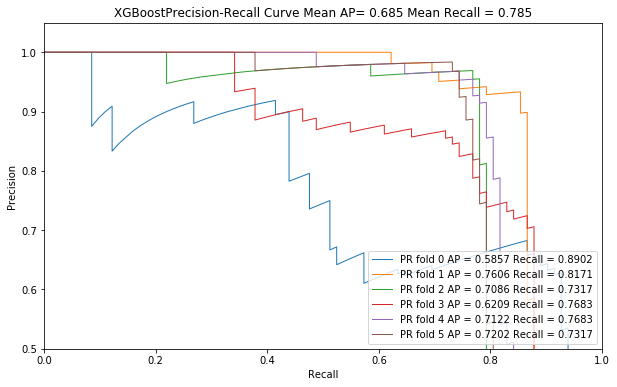

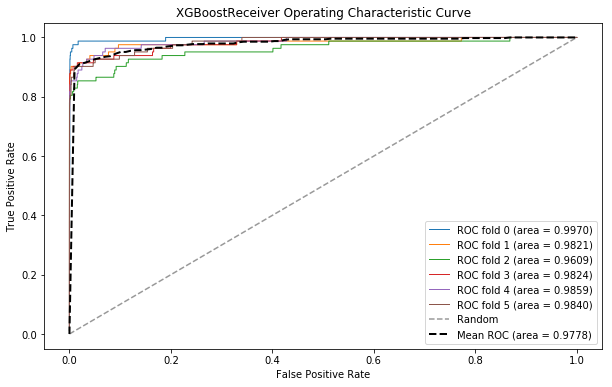

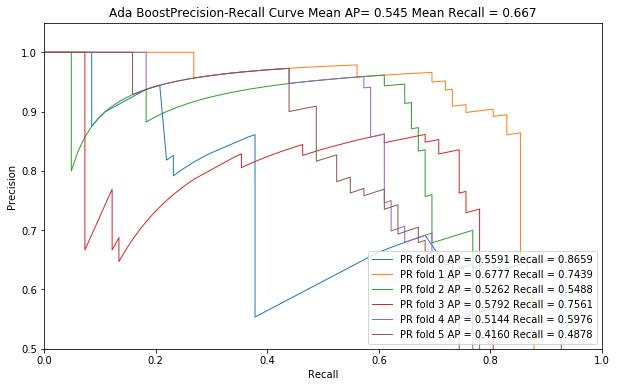

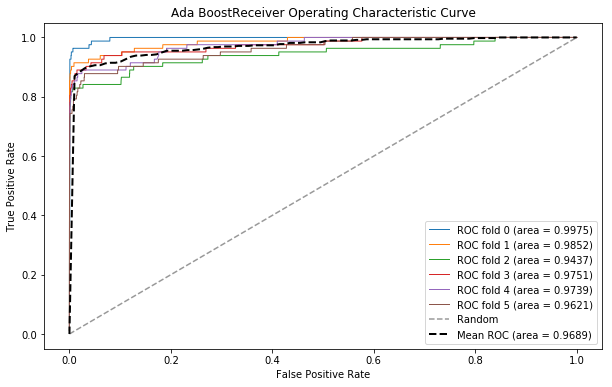

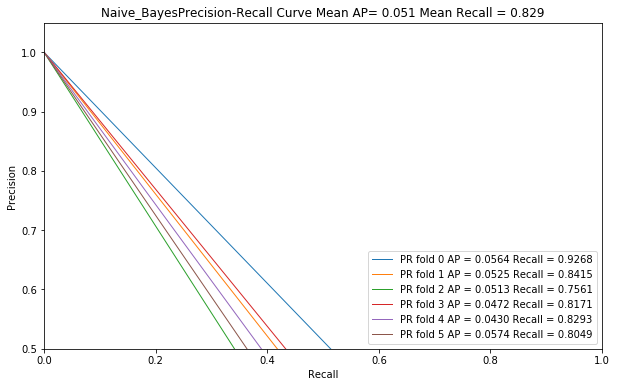

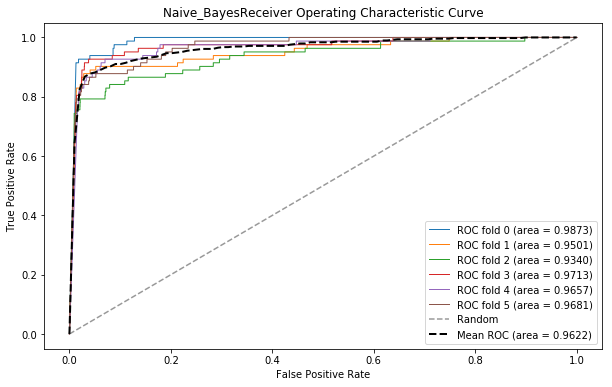

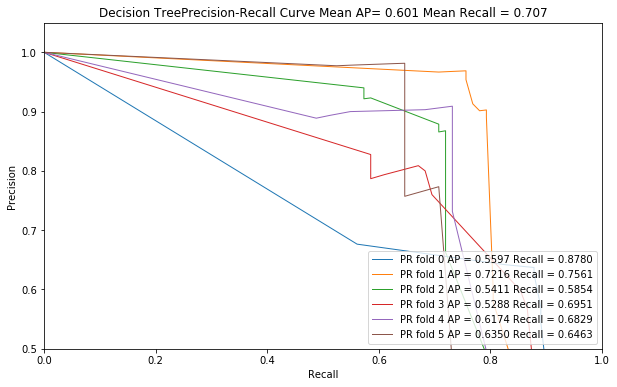

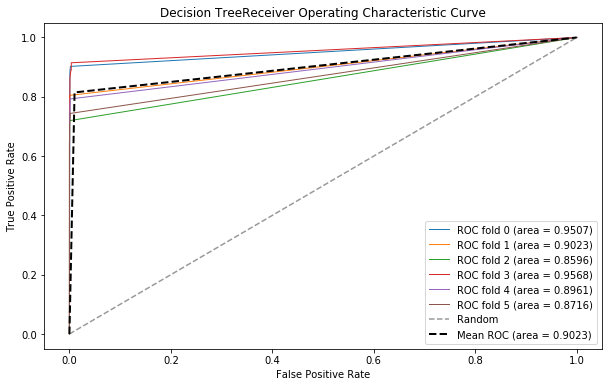

In [157]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42) # avoid overfitting

from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()

import xgboost as xgb
xgboost_clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

fig_index=1
classifiers= {'Naive_Bayes': nb_clf,'Decision Tree':dectree_clf, 'Random Forest':rand_clf,
              'Ada Boost':ada_clf,'XGBoost':xgboost_clf}
for clf_name,clf in classifiers.items():
    draw_precision_recall(clf_name,clf,X,y,fig_index)
    draw_roc_curve(clf_name,clf,X,y,fig_index+1)
    fig_index+=1
    plt.show()

In [159]:
import pickle
pickle.dump(xgboost_clf, open("xgboost.pickle.dat", "wb"))

Naive_Bayes
Average Precision = 0.9567 Recall Score = 0.9567
             precision    recall  f1-score   support

         OK     0.8686    0.9752    0.9188     71030
      Fraud     0.9717    0.8525    0.9082     71027

avg / total     0.9202    0.9138    0.9135    142057

Decision Tree
Average Precision = 0.9978 Recall Score = 0.9978
             precision    recall  f1-score   support

         OK     0.9969    0.9959    0.9964     71030
      Fraud     0.9959    0.9969    0.9964     71027

avg / total     0.9964    0.9964    0.9964    142057

Random Forest
Average Precision = 1.0000 Recall Score = 1.0000
             precision    recall  f1-score   support

         OK     0.9999    0.9998    0.9999     71030
      Fraud     0.9998    0.9999    0.9999     71027

avg / total     0.9999    0.9999    0.9999    142057

Ada Boost
Average Precision = 0.9963 Recall Score = 0.9963
             precision    recall  f1-score   support

         OK     0.9523    0.9766    0.9643     71030
  

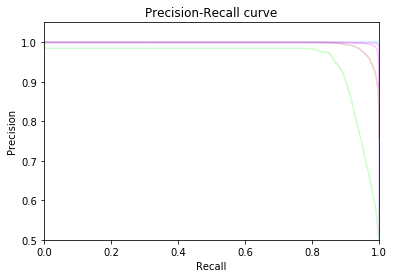

In [38]:
##Code to be removed/ replaced with correct classifier scoring
## Output scores for various classifiers
beta=2.0 # beta greater than 1 due to higher importance of recall vs. precision

for classifier_name,y_pred,y_pred_proba,pt_color in [('Naive_Bayes', nb_y_pred,nb_y_pred_proba,'lime'),
                                        ('Decision Tree',dectree_y_pred,dectree_y_pred_proba,'blueviolet'),
                                        ('Random Forest',rand_y_pred,rand_y_pred_proba,'dodgerblue'),
                                        ('Ada Boost',ada_y_pred,ada_y_pred_proba,'brown'),
                                        ('XGBoost',xgboost_y_pred,xgboost_y_pred_proba,'magenta')]:
    output_classifier_score(classifier_name,y_test,y_pred,y_pred_proba)
    draw_precision_recall(y_test,y_pred_proba)
    #draw_roc_curve(y_test,y_pred_proba)

Since XGBoost performs the best of all the classifiers, we will use this for further exploration. At this point, there are two approaches. The first is to explore data-based methods to improve the balance of the underlying dataset and see if that performs better. The second is to tune hyper-parameters of XGBoost.

In [ ]:
# Explore data-based methods
from imblearn.over_sampling import RandomOverSampler
OverSampler=RandomOverSampler(random_state=42)
X_over,y_over = OverSampler.fit_sample(X, y)

from imblearn.under_sampling import RandomUnderSampler,NearMiss
UnderSampler=RandomUnderSampler(random_state=42)
X_under,y_under = UnderSampler.fit_sample(X, y)

NearMissSampler=NearMiss(random_state=42)
X_nearmiss,y_nearmiss = NearMissSampler.fit_sample(X, y)

from imblearn.combine import SMOTEENN
SMOTESampler=SMOTEENN(random_state=42)
X_smote,y_smote = SMOTESampler.fit_sample(X, y)

In [161]:
import pickle

from sklearn.model_selection import train_test_split

xgboost_clf = pickle.load(open("xgboost.pickle.dat", "rb"))

for sampler_name,X,y in [('OverSampler',X_over,y_over),
                         ('UnderSampler',X_under,y_under),
                         ('NearMiss',X_nearmiss,y_nearmiss),
                        ('SMOTE ENN',X_smote,y_smote)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    y_pred = xgboost_clf.predict(X_test)
    y_pred_proba = xgboost_clf.predict_proba(X_test)
    output_classifier_score(sampler_name,y_test,y_pred,y_pred_proba)

OverSampler
Average Precision = 0.9971 Recall Score = 0.9971
             precision    recall  f1-score   support

         OK     0.8579    1.0000    0.9235     71023
      Fraud     0.9999    0.8347    0.9099     71135

avg / total     0.9290    0.9173    0.9167    142158

UnderSampler
Average Precision = 0.9982 Recall Score = 0.9982
             precision    recall  f1-score   support

         OK     0.8456    1.0000    0.9164       126
      Fraud     1.0000    0.8083    0.8940       120

avg / total     0.9209    0.9065    0.9055       246

NearMiss
Average Precision = 0.9801 Recall Score = 0.9801
             precision    recall  f1-score   support

         OK     0.8446    0.9921    0.9124       126
      Fraud     0.9898    0.8083    0.8899       120

avg / total     0.9154    0.9024    0.9014       246

SMOTE ENN
Average Precision = 0.9955 Recall Score = 0.9955
             precision    recall  f1-score   support

         OK     0.8520    1.0000    0.9201     71030
      Fr

Oversampling and the SMOTE method of sampling performs best. SMOTE is a mix of both under and oversampling

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 300, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter=8)
optimized_GBM.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [10]:
optimized_GBM.cv_results_

{'mean_fit_time': array([  145.41872845,  2450.7132237 ,   159.90643997,   122.75398078,
           86.49034739,    82.06357098,   128.06235576,   121.28832679]),
 'mean_score_time': array([ 0.60759292,  0.63611417,  0.38244042,  0.52046714,  0.3949842 ,
         0.3864171 ,  0.49506216,  0.53755603]),
 'mean_test_score': array([ 0.97920916,  0.97840549,  0.97847301,  0.97844255,  0.97959824,
         0.97979172,  0.97886214,  0.97844442]),
 'mean_train_score': array([ 1.        ,  1.        ,  0.99999237,  1.        ,  0.99997206,
         0.99999925,  0.99999877,  1.        ]),
 'param_max_depth': masked_array(data = [7 5 3 7 3 3 7 5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 1 3 3 5 1 5 3],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 1}

In [12]:
beta=0.9
y_pred = optimized_GBM.predict(X_test)
classifier_scoring('XG Boost',y_test,y_pred,beta)

XG Boost
fbeta_score = 0.8833 AUC = 0.8833 Mathews Coeff = 0.8833
             precision    recall  f1-score   support

         OK     0.9997    0.9999    0.9998     71089
      Fraud     0.9485    0.8142    0.8762       113

avg / total     0.9996    0.9996    0.9996     71202



In [163]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'learning_rate': [0.2, 0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 400, 'random_state':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter = 8)
optimized_GBM.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
optimized_GBM.cv_results_

In [165]:
xgdmat = xgb.DMatrix(X_train, y_train)

In [166]:
our_params = {'eta': 0.2, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Randomized Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'],
                early_stopping_rounds = 100) 
# Look for early stopping that minimizes error

In [169]:
cv_xgb.tail(10)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
761,0.999998,0.000002,1.0,0.0
762,0.999998,0.000002,1.0,0.0
763,0.999998,0.000002,1.0,0.0
764,0.999998,0.000002,1.0,0.0
765,0.999998,0.000002,1.0,0.0
766,0.999997,0.000002,1.0,0.0
767,0.999998,0.000002,1.0,0.0
768,0.999998,0.000002,1.0,0.0
769,0.999998,0.000002,1.0,0.0
770,0.999998,0.000002,1.0,0.0


In [170]:
our_params = {'eta': 0.2, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 765)

In [172]:
import pickle
pickle.dump(xgboost_clf, open("xgboost.pickle.dat", "wb"))

In [ ]:
from sklearn.metrics.scorer import make_scorer

def weighted_cost_scorer(X, y_pred,y_true):
    cost=abs(y_pred-y_true)*X['Amount']
    return cost

weighted_scorer = make_scorer(weighted_cost_scorer, greater_is_better=False)

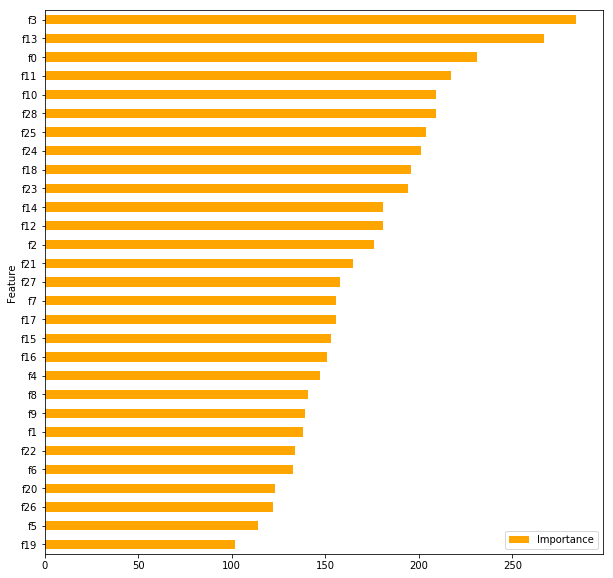

In [173]:
feature_importance_graph(final_gb)

In [174]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')

NameError: name 'importances' is not defined

In [176]:
testdmat = xgb.DMatrix(X_test)
y_pred_proba = final_gb.predict(testdmat)
y_pred[y_pred_proba > 0.5] = 1
y_pred[y_pred_proba <= 0.5] = 0
beta=0.9
classifier_scoring('Tuned XG Boost',y_test,y_pred,beta)
print confusion_matrix(y_pred,y_test)

Tuned XG Boost
fbeta_score = 0.9997 AUC = 0.9997 Mathews Coeff = 0.9997
             precision    recall  f1-score   support

         OK     1.0000    0.9995    0.9997     71030
      Fraud     0.9995    1.0000    0.9997     71027

avg / total     0.9997    0.9997    0.9997    142057

[[70994     0]
 [   36 71027]]


In [17]:
# Exploring cost-sensitive methods
# Create another feature by multiplying amount by the class
amount=data['Amount']
fraud=data['Class']
y = amount*fraud
X= data.drop(['Class','Time','Amount'],axis=1)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rand_clf = RandomForestRegressor(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)

threshold = 10.
rand_y_pred[rand_y_pred > threshold] = 1
rand_y_pred[rand_y_pred <= threshold] = 0

In [36]:
print rand_y_pred>0.
beta=0.9
classifier_scoring('Modified Classifier using RandomForestRegressor',y_test,rand_y_pred,beta)

[False False False ..., False False False]
Modified Classifier using RandomForestRegressor
fbeta_score = 0.0000 AUC = 0.0000 Mathews Coeff = 0.0000
             precision    recall  f1-score   support

         OK     0.9984    1.0000    0.9992     71089
      Fraud     0.0000    0.0000    0.0000       113

avg / total     0.9968    0.9984    0.9976     71202

